Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [18]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image

[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318544e-04
    2.67124303e-02]]


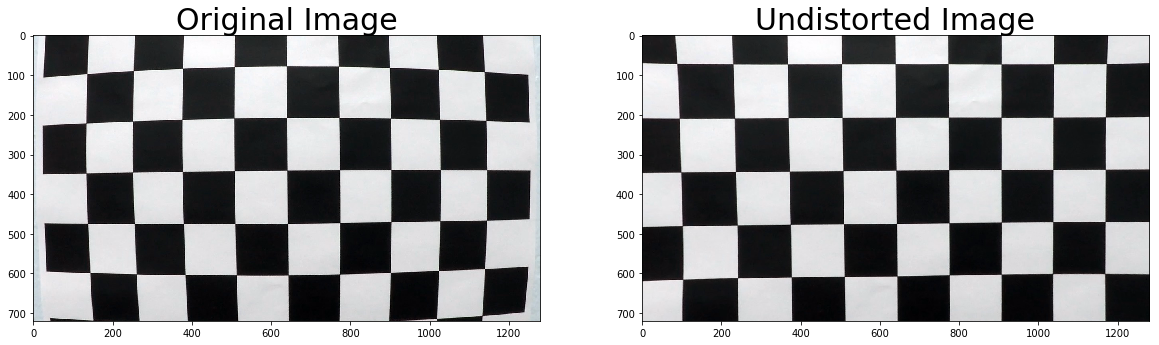

In [19]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print (dist)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('reportPict/undist_calibration1.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Images and Video Pipeline
===

### Run the code in the cell below to undistort source images

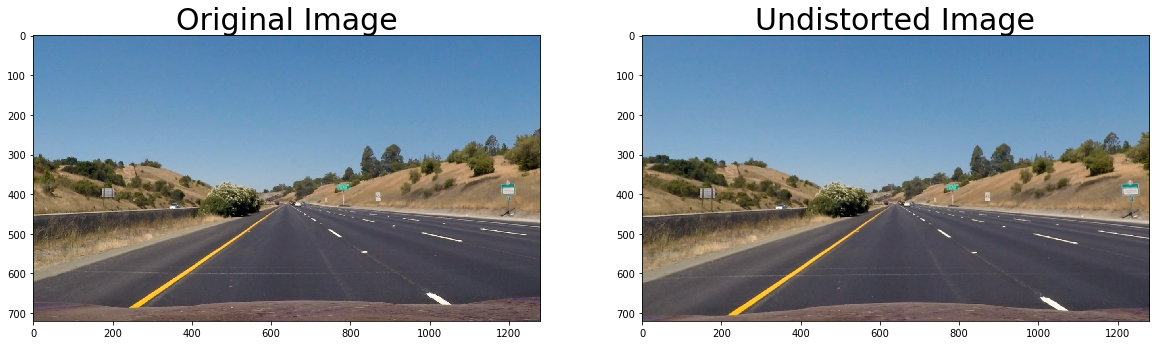

In [7]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) ) # read distortion coeficinets calculated above
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
images = glob.glob('test_images/*.jpg')
#images = glob.glob('challenge_images/*.jpg')
#images = glob.glob('harder_challenge/*.jpg')
undist = []
for imgName in images:
    img = cv2.imread(imgName)
    undistImg = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('reportPict/'+imgName ,undistImg)
    undist.append(undistImg)

# Visualize example
img = cv2.imread(images[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(undist[0], cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

### Run the code in the cell below to convert images to binary format

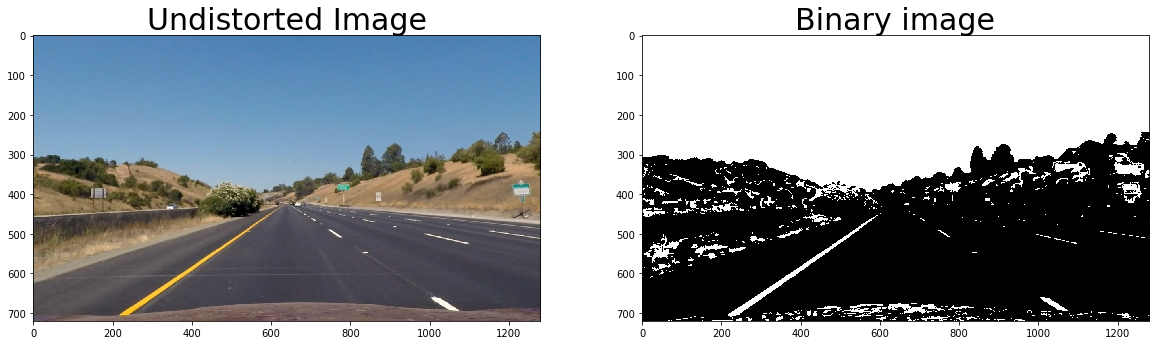

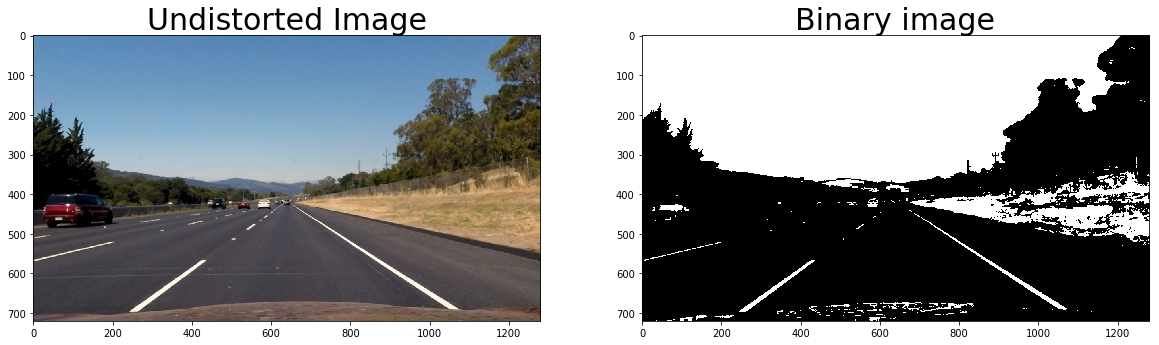

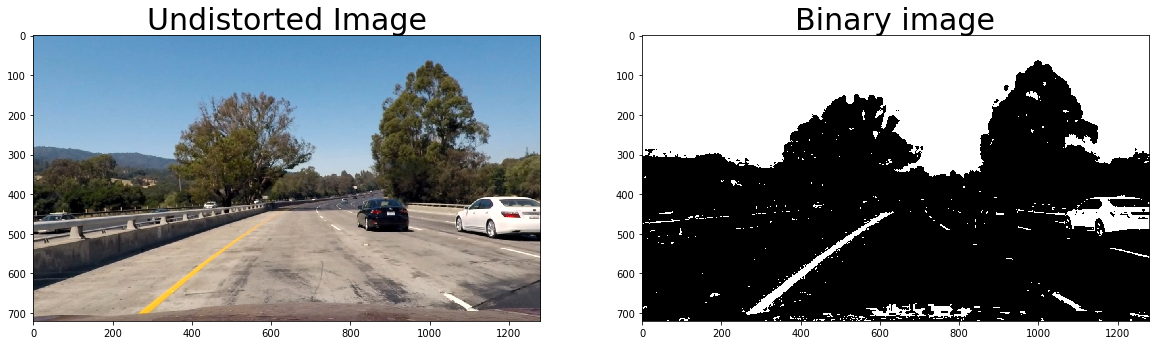

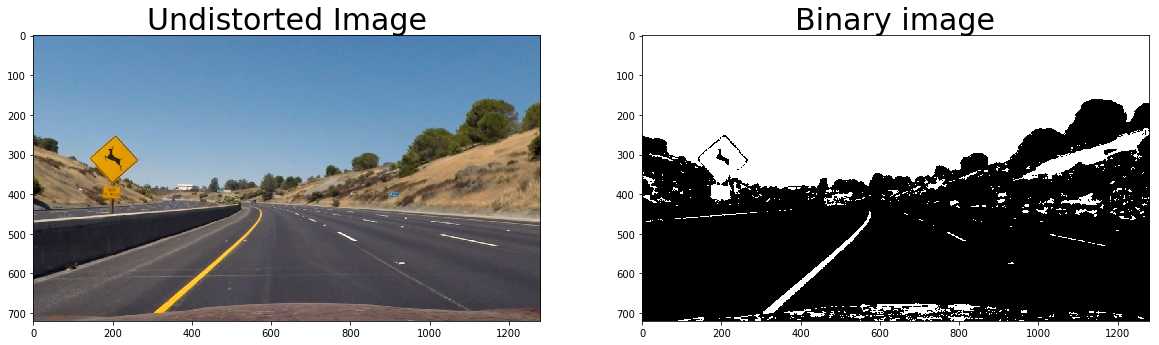

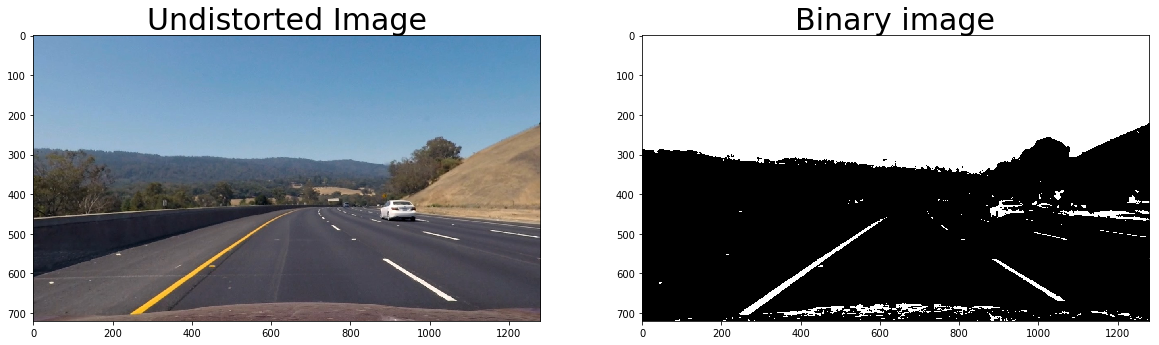

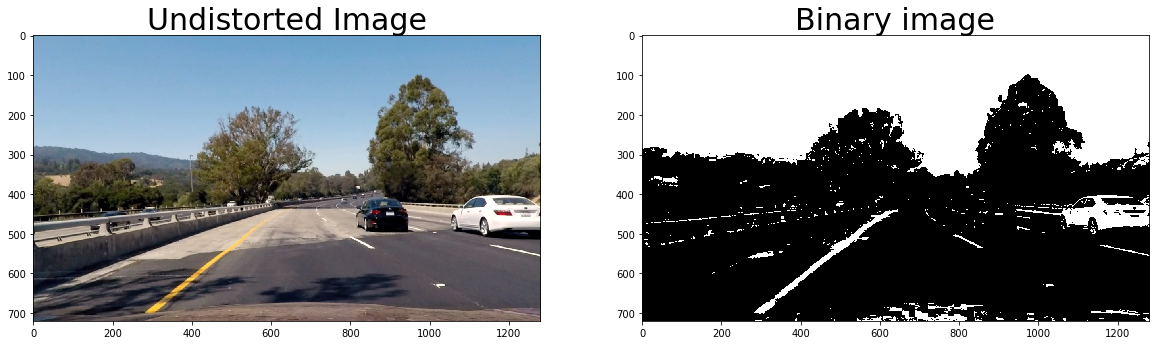

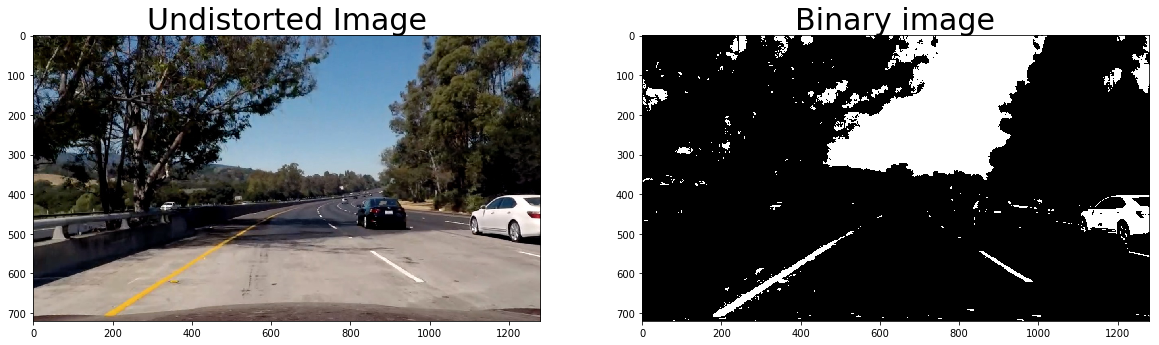

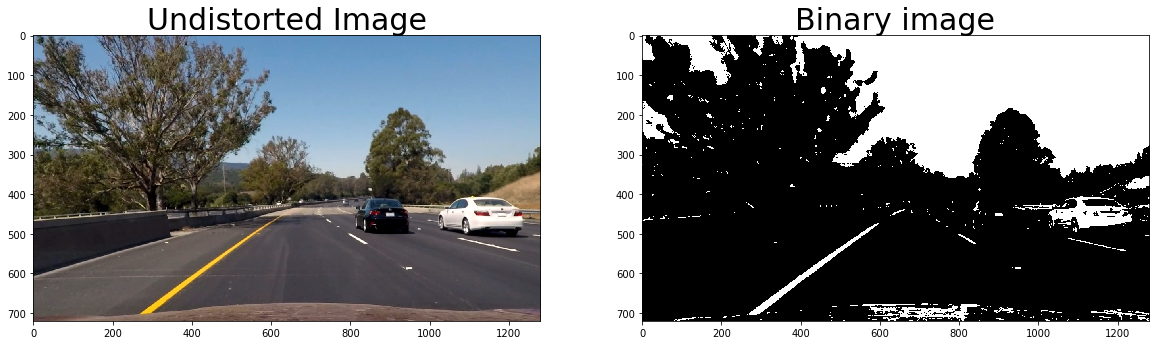

In [8]:
def convertToBinMix(img, yellowH=(20, 30), yellowS=(40, 255), whiteL=(205,255), sxThresh=(10, 255), lxThresh=(40, 255), dirThreshold=(0.8, 1.1)):
    """
    This functions returns binary image where lines are marked with '1' 
    
    Parameters
    ----------
    img : array
        Input BGR image
    yellowH : tuple
        threshold for yellow Hue channel
    yellowS : tuple
        threshold for yellow Saturation channel   
    whiteL : tuple
        threshold for white light channel  
    sxThresh : tuple
        threshold for X sobel over saturation channel
    sxThresh : tuple
        threshold for X sobel over light channel  
    dirThreshold
        threshold for sobel direction over light and saturation channel 
    Returns
    -------
    float
        Calculated radius
    """ 
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    hChannel = hls[:,:,0]
    lChannel = hls[:,:,1]
    sChannel = hls[:,:,2]
    
    # Sobel x over l channel
    sobelx = cv2.Sobel(lChannel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(lChannel, cv2.CV_64F, 0, 1) # Take the derivative in y
    
    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx))# Calculate the direction of the gradient in radians
    
    absSobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaledSobel = np.uint8(255*absSobelx/np.max(absSobelx))
    
    # Threshold x gradient
    lxBinary = np.zeros_like(scaledSobel)
    lxBinary[(scaledSobel >= lxThresh[0]) & (scaledSobel <= lxThresh[1]) & (direction >= dirThreshold[0]) & (direction <= dirThreshold[1])] = 1    
 
    # Sobel x over s channel
    sobelx = cv2.Sobel(sChannel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(sChannel, cv2.CV_64F, 0, 1) # Take the derivative in y
    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx))# Calculate the direction of the gradient in radians
    absSobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaledSobel = np.uint8(255*absSobelx/np.max(absSobelx))
    # Threshold x gradient
    sxBinary = np.zeros_like(scaledSobel)
    sxBinary[(scaledSobel >= sxThresh[0]) & (scaledSobel <= sxThresh[1]) & (direction >= dirThreshold[0]) & (direction <= dirThreshold[1])] = 1   


    # Threshold yellow pixels
    yellowBinary = np.zeros_like(hChannel)
    yellowBinary[(hChannel >= yellowH[0]) & (hChannel <= yellowH[1]) & (sChannel >= yellowS[0]) & (sChannel <= yellowS[1])] = 1
    
    # threshold white pixels
    whiteBinary = np.zeros_like(lChannel)
    whiteBinary[(lChannel >= whiteL[0]) & (lChannel <= whiteL[1])] = 1
    # Stack each channel 
    resultBin = np.zeros_like(whiteBinary)
    resultBin[(yellowBinary == 1) | (whiteBinary == 1) | (lxBinary == 1) | (sxBinary == 1)] = 1
    return resultBin


def convertToBinColors(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
    #bgr thresholding for yellow
    lower = np.array([0,140,170],dtype = "uint8")
    upper = np.array([170, 255, 255],dtype = "uint8")
    bgrYellow = cv2.inRange(image, lower, upper)

    #bgr thresholding for white
    lower = np.array([200,100,100],dtype = "uint8")
    upper = np.array([255, 255, 255],dtype = "uint8")
    bgrWhite = cv2.inRange(image, lower, upper)

    #hls thresholding for yellow
    lower = np.array([15,90,40],dtype = "uint8")
    upper = np.array([30, 255, 255],dtype = "uint8")
    hlsYellow = cv2.inRange(hls, lower, upper)
    
    binary = np.zeros_like(hlsYellow)
    binary [(hlsYellow == 255) | (bgrYellow==255) | (bgrWhite==255)]= 1
    return binary

def convertToBinNotGray(image):  
    #difference between chnnels is small for gray
    b = image[:,:,0].astype('int16')
    g = image[:,:,1].astype('int16')
    r = image[:,:,2].astype('int16')
    bMinG = abs(b-g).astype('uint8')
    bMinR = abs(b-r).astype('uint8')
    gMinR = abs(g-r).astype('uint8')
    diff=20
    diffGray = np.zeros_like(bMinG)
    #diffGray[(bMinG <= diff) & (bMinR <= diff) & (gMinR <= diff)] = 1 #challenge
    diffGray[(bMinG <= diff)  & (gMinR <= diff)] = 1
    #bgr thresholding for gray
    lower = np.array([0,0,0],dtype = "uint8")
    upper = np.array([185, 185, 185],dtype = "uint8")
    maybeBgrGray = cv2.inRange(image, lower, upper)
    upper = np.array([120, 120, 120],dtype = "uint8")
    alwaysBgrGray = cv2.inRange(image, lower, upper)
    
    #hls thresholding for gray
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    lower = np.array([8,0,0],dtype = "uint8")
    upper = np.array([18, 200, 90],dtype = "uint8")
    hlsGray = cv2.inRange(hls, lower, upper)
    binary = np.zeros_like(diffGray)
    binary [((maybeBgrGray == 0) | (diffGray==0)) & (alwaysBgrGray == 0) & (hlsGray==0)]= 1
    #binary [((maybeBgrGray == 0) | (diffGray==0)) & (alwaysBgrGray == 0)]= 1
    #binary [diffGray == 0]= 1
    return binary   
binaryList = []
for undistImg in undist:
    #binaryList.append(convertToBinColors(undistImg)) # Color thresholding
    #binaryList.append(convertToBinMix(undistImg)) # Mixed thresholding
    binaryList.append(convertToBinNotGray(undistImg)) # not gray thresholding
# Visualize all undistorted images and binary versions too
i=0
for undistImg, binImg in zip(undist, binaryList):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(undistImg, cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=30)
    ax2.imshow(binImg, cmap='gray')
    i=i+1
    cv2.imwrite('reportPict/'+'lol'+str(i)+'.jpg' ,binImg*255)
    ax2.set_title('Binary image', fontsize=30)

### Run the code in the cell below to transform binary format to bird eye view

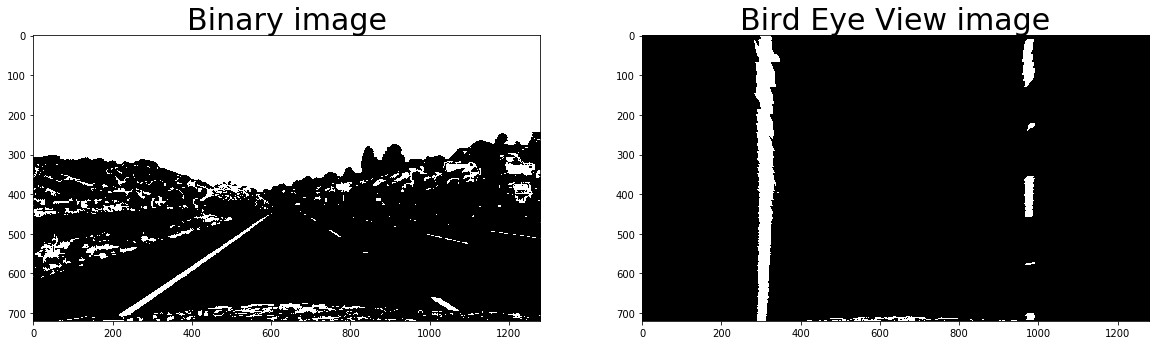

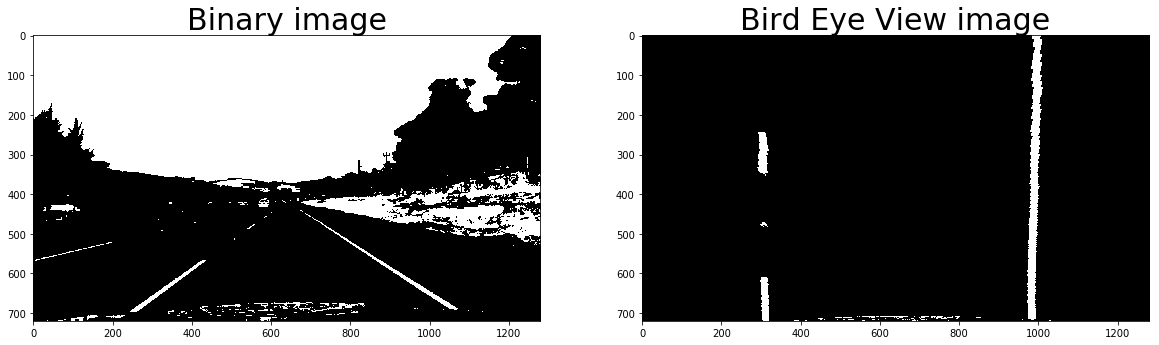

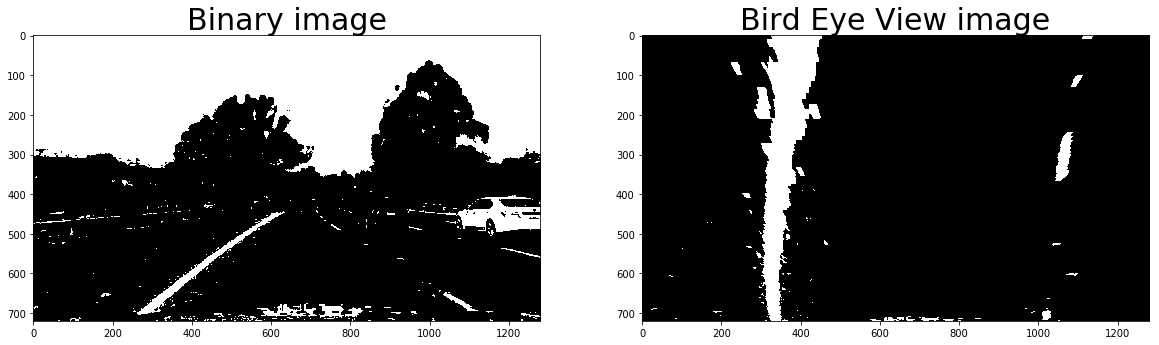

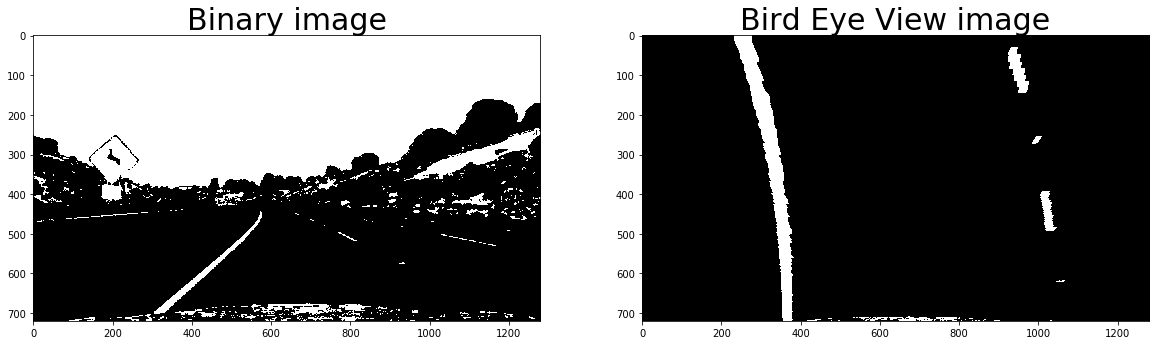

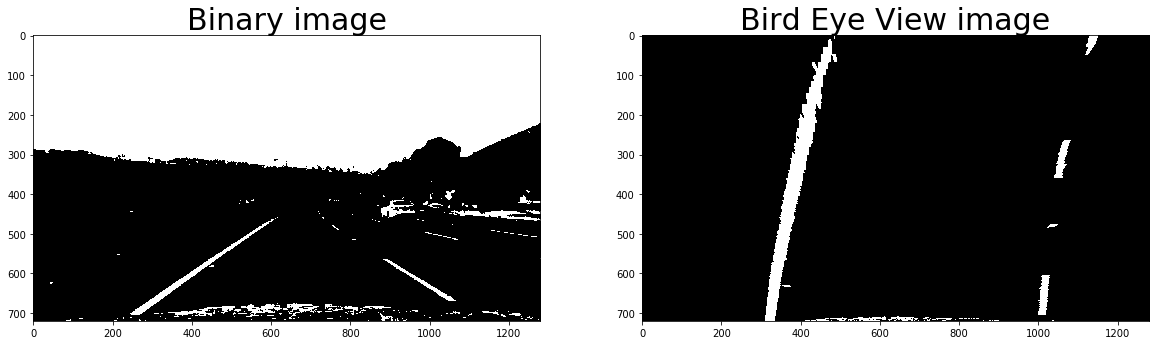

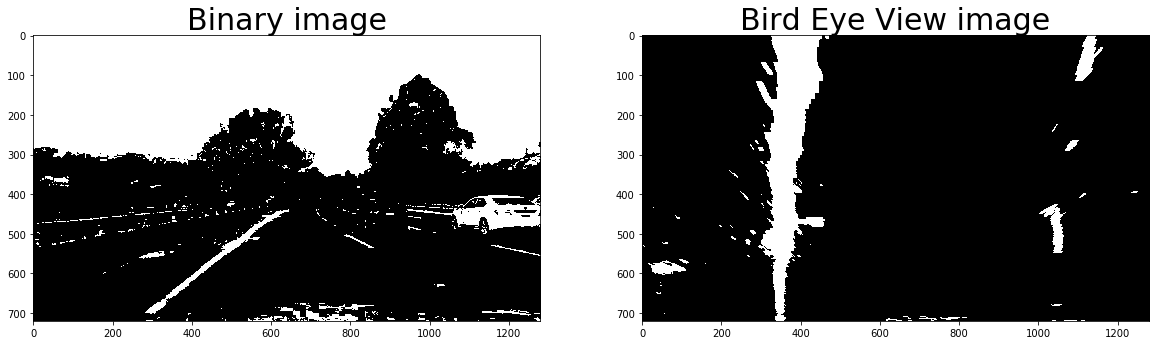

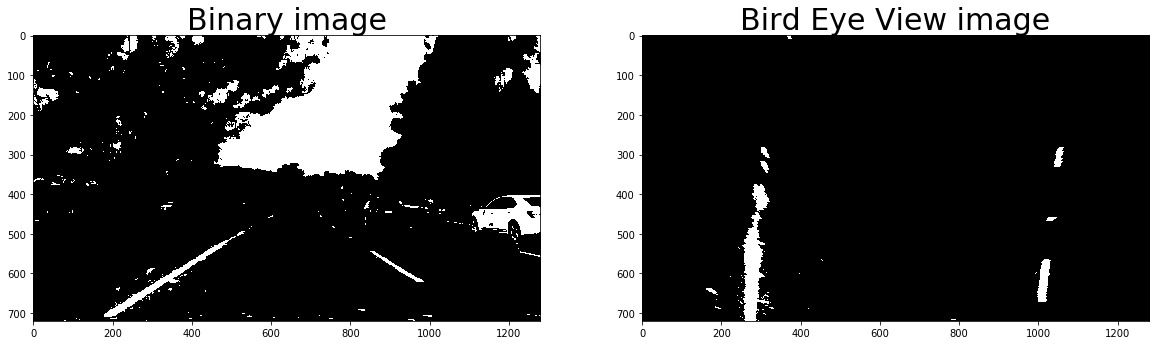

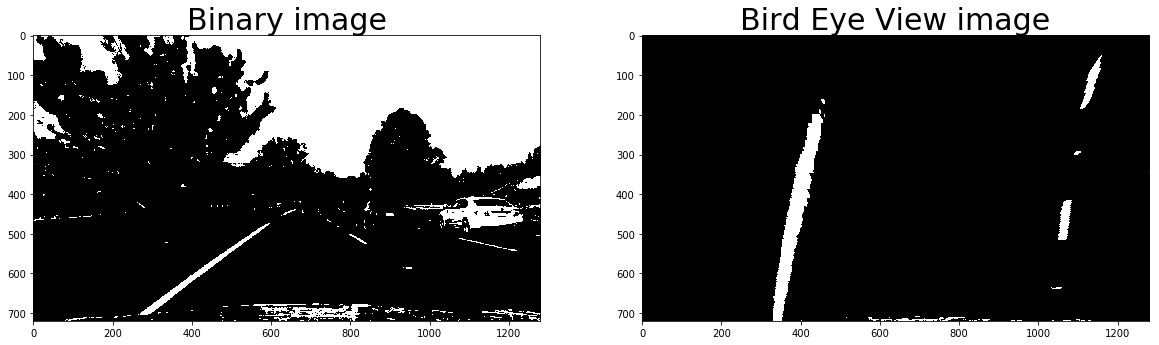

In [9]:
img_size = (binaryList[0].shape[1], binaryList[0].shape[0])
offset = 300
src = np.float32([[580,460], [702,460], [233,700], [1075,700]]) # Project video
#src = np.float32([[588,490], [740,490], [309,710], [1117,710]]) # Challenge video
dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                 [offset, img_size[1]], 
                 [img_size[0]-offset, img_size[1]]])
birdEyeList = []
for binaryImg in binaryList:
    M = cv2.getPerspectiveTransform(src, dst)
    birdEyeList.append(cv2.warpPerspective(binaryImg, M, img_size , flags=cv2.INTER_LINEAR))
i=0
# Visualize all binary images and birdeye versions
for binImg, birdEyeImg in zip(binaryList, birdEyeList):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(binImg, cmap='gray')
    ax1.set_title('Binary image', fontsize=30)
    ax2.imshow(birdEyeImg, cmap='gray')
    ax2.set_title('Bird Eye View image', fontsize=30)
    #i= i+1
    #cv2.imwrite('reportPict/'+str(i)+'.jpg' ,birdEyeImg*255)

### Run the code in the cell below to detect lines

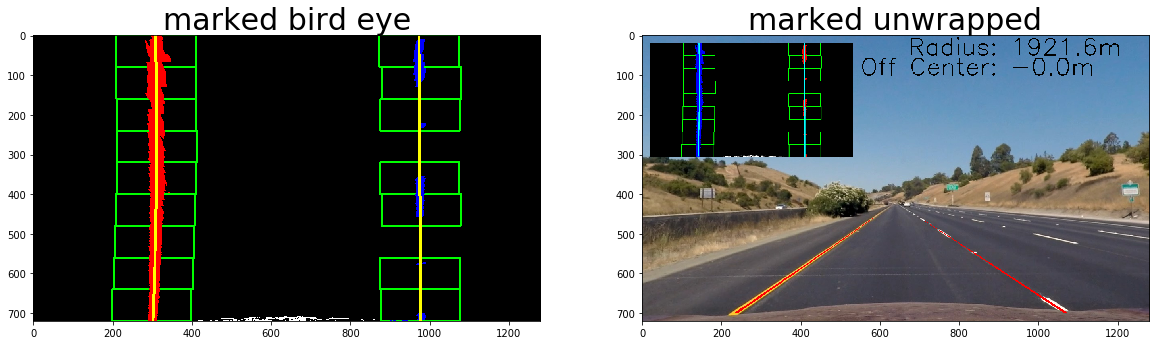

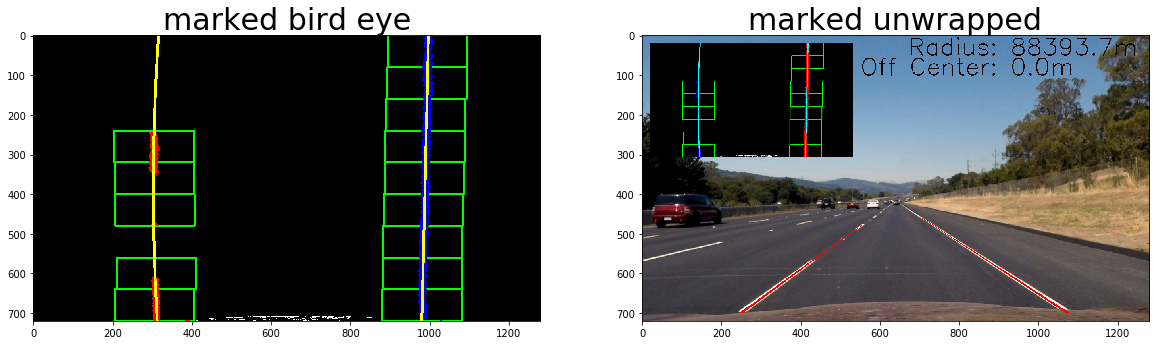

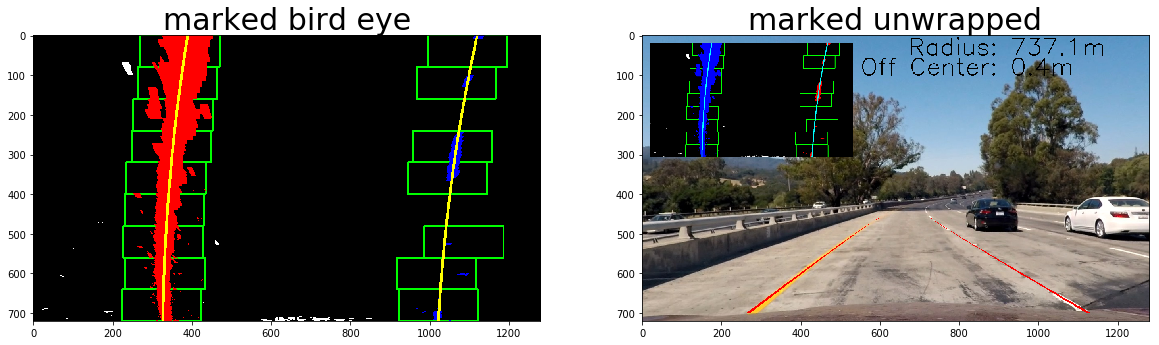

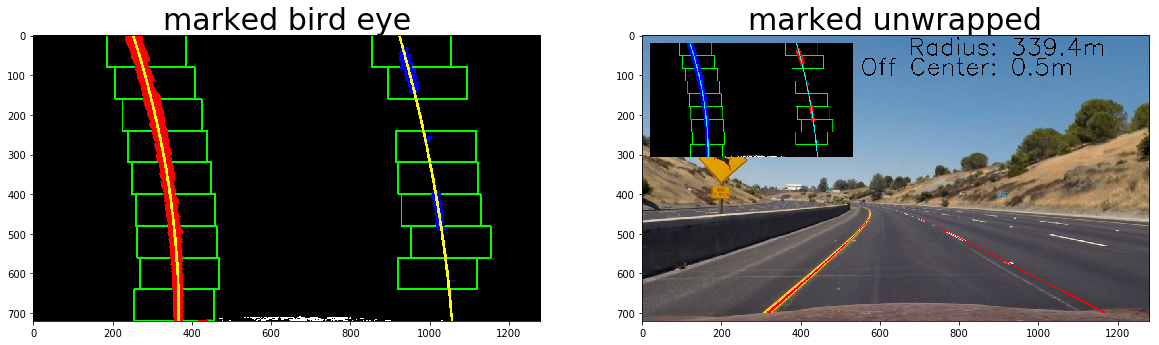

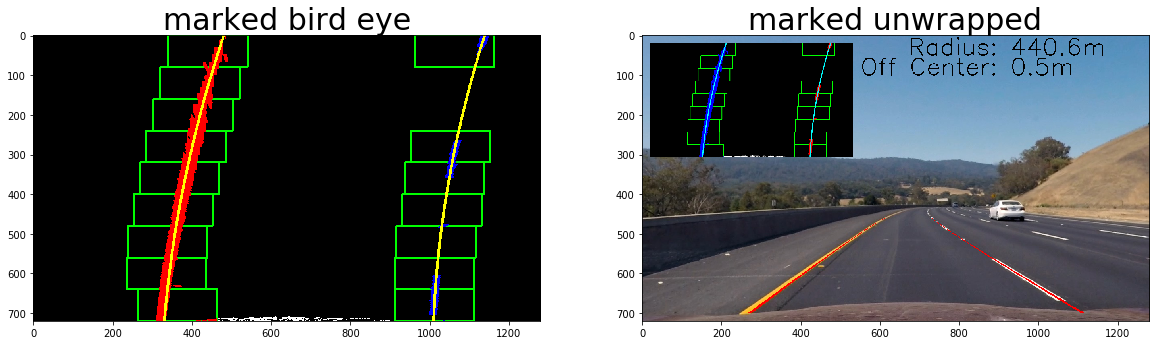

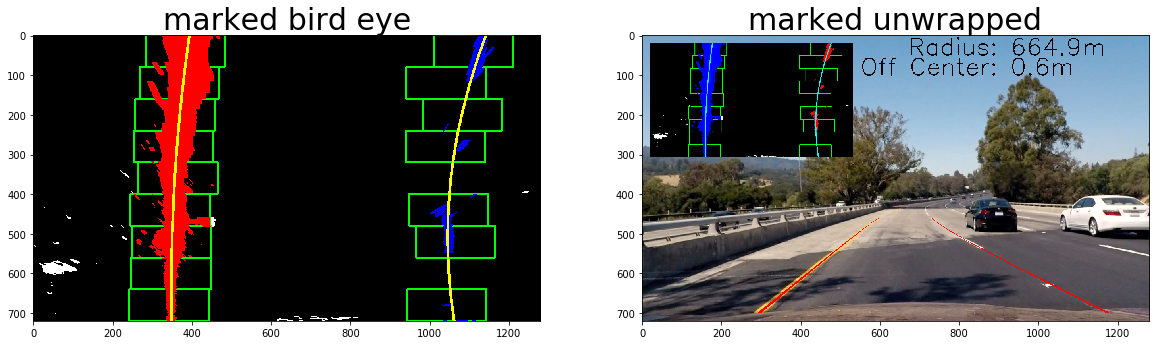

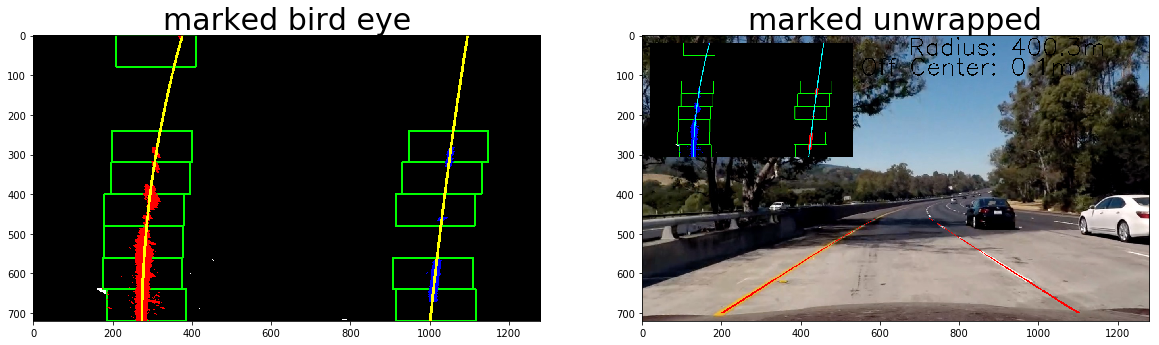

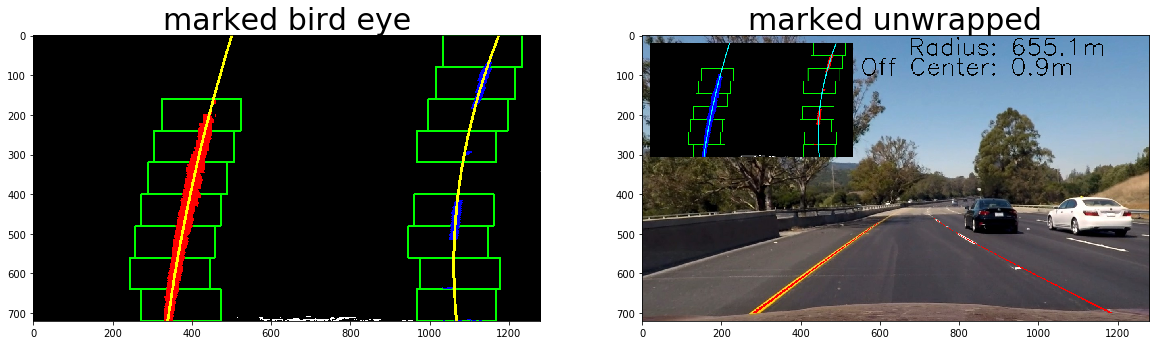

In [10]:
# Conversions in x and y from pixels space to meters
ymPerPix = 3.0/(358.0-462.0) # based on dashed line measured on bird eye view and real life line legth of 3m
xmPerPix = 3.7/(978.0-302.0) # based on line width measured on bird eye view and real life line width of 3.7m
# polyCoef - Coeficients of polymial of left line in pixel space
# yEval - where radius should be calculated in y pixels
def calculateRadius(polyCoef, yEval):
    """
    calculate radius of quadratic function
    
    Parameters
    ----------
    polyCoef : array
        Coeeficients of quadratic poly fit 
    yEval : float
        Argument for which radius is calculated
    Returns
    -------
    float
        Calculated radius
    """ 
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    polyCoefMeters = np.array([polyCoef[0]*(xmPerPix/(ymPerPix**2)), polyCoef[1]*(xmPerPix/ymPerPix), polyCoef[2]])
    # Calculate the radius of curvature
    #Rcurve=((1+(2Ay+B)^2)^3/2)/∣2A∣
    radius = ((1 + (2*polyCoefMeters[0]*yEval*ymPerPix + polyCoefMeters[1])**2)**1.5) / np.absolute(2*polyCoefMeters[0])
    return radius
                         
 
def squarefit(pixX, pixY):
    """
    Fit a second order polynomial
    
    Parameters
    ----------
    pixX : array
        X coordinates of pixels to be fitted
    pixY : array
        Y coordinates of pixels to be fitted
    Returns
    -------
    array
        Coeeficients of quadratic poly fit 
    """ 
    if pixX.size == 0 or pixY.size == 0:
        return None
    # Fit a second order polynomial
    return np.polyfit(pixY, pixX, 2)

def calcQuadFitVal(squareFit, arg):
    """
    calculate quadratic function value
    
    Parameters
    ----------
    squareFit : array
        Coeeficients of quadratic poly fit 
    arg : float
        Argument for which value is calculated
    Returns
    -------
    float
        Value for given argument
    """ 
    return squareFit[0]*arg**2 + squareFit[1]*arg + squareFit[2]


def pixelsSanityCheck(pixY, minpixels, imgShape):
    """
    Perform sanity checks on line pixels
    
    Parameters
    ----------
    pixY : array
        Y coordinates of line pixels
    minpixels : int
        Minimum number of pixels
    imgShape: array
        shape of image
    Returns
    -------
    bool
        True if check was successful False otherwise
    """ 
    middleY = int(imgShape[0]/2)
    if len(pixY) < minpixels or np.amax(pixY) < middleY or np.amin(pixY) > middleY:
        return False 
    return True

def lineFitSanitycheck(leftFit, rightFit, margin, imgShape):
    """
    Perform sanity checks on fitted lines
    
    Parameters
    ----------
    leftFit : array
        Coeeficients of left line quadratic poly fit 
    rightFit : array
        Coeeficients of right line quadratic poly fit
    margin : integer
        margin detected line width
    imgShape: array
        shape of image
    Returns
    -------
    bool
        True if check was successful False otherwise
    """ 
    bottomY = imgShape[0]
    imageHalf = int(imgShape[1]/2)
    bottomRight = calcQuadFitVal(rightFit, bottomY)
    bottomLeft = calcQuadFitVal(leftFit, bottomY)
    #check if lines are on correct sides
    if bottomLeft > imageHalf or bottomRight < imageHalf:
        return False
    bottomWidth = bottomRight - bottomLeft
    #check if line is wide enougth
    if bottomWidth < (imageHalf - margin):
        return False
    #check if line width does not warry more than margin
    for y in range(bottomY-1):
        widthDiff = abs((calcQuadFitVal(rightFit, y) - calcQuadFitVal(leftFit, y)) - bottomWidth)
        if widthDiff > margin:
            return False
    return True


def markLines(img, undistImg, prevLeftFit = None, prevRightFit = None, margin = 100, minpix = 50, nwindows = 9):
    """
    This functions detect lines, calculate curvature and car position using binary bird eye image and marks them on BGR image
    
    Parameters
    ----------
    img : array
        input bird eye view binary image
    undistImg : array
        input undistorted image on which lines and curvatures will be marked
    prevLeftFit : array
        Coeeficients of lefy line quadratic poly fit in previous frame 
    prevRightFit : array
        Coeeficients of right line quadratic poly fit in previous frame 
    margin : integer
        search margin for new line
    minpix: integer
        minimum number of pixel in one window to detect the line
    nwindows: integer
        Number of sliding windows used to search each line
    Returns
    -------
    array
        Debug bird eye view image with right and left line marked
    array
        BGR image with marked lines, debug image in up left corner, radius and car possition printed in up right corner
    array
        Coeeficients of left line quadratic poly fit 
    array
        Coeeficients of right line quadratic poly fit 
    """
    #initialize variables used later in the code
    offCenter = None
    finalRadius =None
    leftFit = None
    rightFit = None
    outputImg = undistImg.copy()
    leftFit = [0,0,0]
    rightFit = [0,0,0]
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    debugImg = np.uint8(np.dstack((img, img, img))*255)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # try to find lines usign previus fit 
    if prevLeftFit != None and prevRightFit != None:
        left_lane_inds = ((nonzerox > calcQuadFitVal(prevLeftFit, nonzeroy) - margin) & 
                          (nonzerox < calcQuadFitVal(prevLeftFit, nonzeroy) + margin)) 

        right_lane_inds = ((nonzerox > calcQuadFitVal(prevRightFit, nonzeroy) - margin) &
                           (nonzerox < calcQuadFitVal(prevRightFit, nonzeroy) + margin))
        
        lPixX = nonzerox[left_lane_inds]
        lPixY = nonzeroy[left_lane_inds]
        rPixX = nonzerox[right_lane_inds]
        rPixY = nonzeroy[right_lane_inds]
        if pixelsSanityCheck(rPixY, minpix, img.shape) and pixelsSanityCheck(lPixY, minpix, img.shape):
            leftFit = squarefit(lPixX, lPixY)
            rightFit = squarefit(rPixX, rPixY)
        if rightFit == None or leftFit == None or lineFitSanitycheck(leftFit, rightFit, margin, img.shape) == False:
            left_lane_inds = []
            right_lane_inds = []
            leftFit = None
            rightFit = None
    #check if both lines were found where were expected if not execute full search
    if len(right_lane_inds) < nwindows*minpix or len(right_lane_inds) < nwindows*minpix:
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image


            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                left_lane_inds.append(good_left_inds)
                # Append only when line is detected
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                cv2.rectangle(debugImg,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 4)

            if len(good_right_inds) > minpix: 
                right_lane_inds.append(good_right_inds)
                # Append only when line is detected
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                cv2.rectangle(debugImg,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 4)
        if len(left_lane_inds) !=0 and len(right_lane_inds) !=0 :
            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            lPixX = nonzerox[left_lane_inds]
            lPixY = nonzeroy[left_lane_inds]
            rPixX = nonzerox[right_lane_inds]
            rPixY = nonzeroy[right_lane_inds]
            if pixelsSanityCheck(rPixY, minpix, img.shape) and pixelsSanityCheck(lPixY, minpix, img.shape):
                leftFit = squarefit(lPixX, lPixY)
                rightFit = squarefit(rPixX, rPixY)

    #if sanity check still fails use line detected in previous frame
    if rightFit == None or leftFit == None or lineFitSanitycheck(leftFit, rightFit, margin, img.shape) == False:
        leftFit = prevLeftFit
        rightFit= prevRightFit
    else:
        debugImg[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        debugImg[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if leftFit != None and rightFit != None:
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = calcQuadFitVal(leftFit, ploty)
        right_fitx = calcQuadFitVal(rightFit, ploty)

        cv2.polylines(debugImg, np.int_(np.dstack((left_fitx, ploty))), False, (255,255, 0),5)
        cv2.polylines(debugImg, np.int_(np.dstack((right_fitx, ploty))), False, (255,255, 0),5)
        Munwrap = cv2.getPerspectiveTransform(dst, src)
        #select lines by color
        lineMask = cv2.inRange(debugImg, np.array([255,255,0]), np.array([255,255,0]))
        img_size = (lineMask.shape[1], lineMask.shape[0])
        maskUnwraped = cv2.warpPerspective(lineMask, Munwrap, img_size , flags=cv2.INTER_LINEAR)
        outputImg[maskUnwraped.astype(bool)] = np.array([0,0,255]) #overlay markd lines

        #Calculate Radius for left and right fit and select one with more pixels
        leftRadius = calculateRadius(leftFit, debugImg.shape[0])
        rightRadius = calculateRadius(rightFit, debugImg.shape[0])
        if len(left_lane_inds) > len(right_lane_inds):
            finalRadius = leftRadius
        else:
            finalRadius = rightRadius
        #Calculate how far of center the car is
        offCenter = ((leftx_base + rightx_base) - debugImg.shape[1]) * xmPerPix
        
    #print('left', left_fit, 'right', right_fit)
    #print(leftRadius, 'm', rightRadius, 'm')  
    if offCenter != None and finalRadius != None:
        cv2.putText(outputImg, 'Radius: ' + str("{0:.1f}".format(finalRadius)) +'m', (670,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), thickness=2)
        cv2.putText(outputImg, 'Off Center: ' + str("{0:.1f}".format(offCenter)) +'m', (550,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), thickness=2)
    smallDebug = cv2.resize(debugImg, (0, 0), fx=0.4, fy=0.4)
    outputImg[20:20 + smallDebug.shape[0], 20:20 + smallDebug.shape[1], :] = smallDebug
    return debugImg, outputImg, leftFit, rightFit


markedList = []
unwrapMarkedList = []
Munwrap = cv2.getPerspectiveTransform(dst, src)
for birdEyeImg, undistImg in zip(birdEyeList,undist):
    markedImg, undistImg, leftFit, rightFit = markLines(birdEyeImg, undistImg)
    markedList.append(markedImg)
    unwrapMarkedList.append(undistImg)
    
# show marked images 
for markedImg, unwrapMarkedImg in zip(markedList,unwrapMarkedList):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(markedImg)
    ax1.set_title('marked bird eye', fontsize=30)
    ax2.imshow(cv2.cvtColor(unwrapMarkedImg, cv2.COLOR_BGR2RGB))
    #ax2.imshow(unwrapMarkedImg, cmap='gray')
    ax2.set_title('marked unwrapped', fontsize=30)

### Video processing function

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
prevLeftFit = None
prevRightFit = None
def processImage(image):
    """
    This functions detect lines, calculate curvature and car position on RGB image
    
    This function combine full pipeline detecting lines on RGB image

    Parameters
    ----------
    image : array
        Input RGB image to be converted.

    Returns
    -------
    array
        Image with detected lines, curvature radius and car possition overlaid.
    """
    global prevLeftFit
    global prevRightFit
    imageBGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #convert image to BGR because image pipeline accepts this format
    undistImg = cv2.undistort(imageBGR, mtx, dist, None, mtx)
    binImg = convertToBinNotGray(undistImg)
    img_size = (binImg.shape[1], binImg.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    wrapedImg = cv2.warpPerspective(binImg, M, img_size , flags=cv2.INTER_LINEAR)
    markedImg, undistImg, prevLeftFit, prevRightFit = markLines(wrapedImg, undistImg, prevLeftFit = prevLeftFit, prevRightFit = prevRightFit)
    return cv2.cvtColor(undistImg, cv2.COLOR_BGR2RGB) #Return RGB image
    


### Process project video

In [12]:
videoName = 'project_video.mp4'
vidOutput = 'output_videos/' + videoName
clip1 = VideoFileClip(videoName)
prevLeftFit = None
prevRightFit = None
whiteClip = clip1.fl_image(processImage) 
%time whiteClip.write_videofile(vidOutput, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:24<00:00,  6.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 3min 25s


### Play the  projec video

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vidOutput))

### Process challenge video

In [13]:
src = np.float32([[588,490], [740,490], [309,710], [1117,710]]) # Challenge video
chalVidName = 'challenge_video.mp4'
chalVidOutput = 'output_videos/' + chalVidName
clip1 = VideoFileClip(chalVidName)
prevLeftFit = None
prevRightFit = None
whiteClip = clip1.fl_image(processImage) 
%time whiteClip.write_videofile(chalVidOutput, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [01:18<00:00,  6.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 1min 19s


In [ ]:
for time in range(17):
    clip1.save_frame('challenge_images/image'+str(time)+'.jpg', t=time)

### Play the  challenge video

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chalVidOutput))

### Process harder challenge video

In [6]:
hardVidName = 'harder_challenge_video.mp4'
hardVidOutput = 'output_videos/' + hardVidName
clip1 = VideoFileClip(hardVidName)
prevLeftFit = None
prevRightFit = None
whiteClip = clip1.fl_image(processImage) 
%time whiteClip.write_videofile(hardVidOutput, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████████████████████████████████▉| 1199/1200 [04:26<00:00,  5.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

Wall time: 4min 28s


In [ ]:
for time in range(17):
    clip1.save_frame('harder_challenge/image'+str(time)+'.jpg', t=time)

###  Play the  challenge video

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hardVidOutput))